In [1]:
%matplotlib inline
import numpy as np
import power_laws
import rubisco_data
import matplotlib.colors
import seaborn as sns
import pandas as pd

from scipy.stats import linregress
from scipy.stats import gmean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(merged_kin_df.shape[0], 'data points post-merge')

378 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
305 data points post-merge


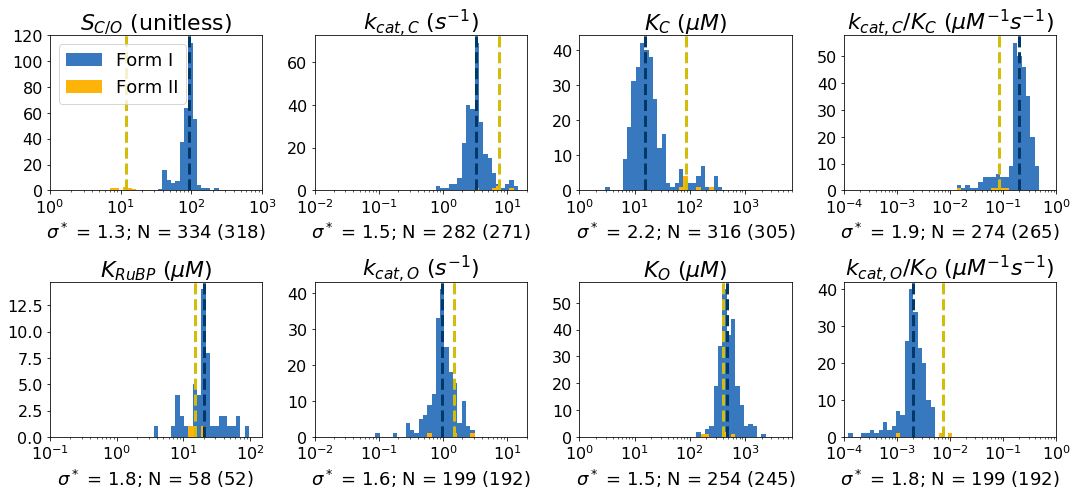

In [4]:
# Description of the data set
figure = plt.figure(figsize=(15,7))

cols = ['S', 'vC', 'KC', 'kon_C', 'KRuBP', 'vO', 'KO', 'kon_O']
titles = {'S': '$S_{C/O}$',
          'vC': '$k_{cat,C}$',
          'KC': '$K_C$',
          'vO': '$k_{cat,O}$',
          'KO': '$K_O$',
          'kon_C': '$k_{cat,C}/K_C$',
          'kon_O': '$k_{cat,O}/K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless',
         'vC': '$s^{-1}$',
         'KC': '$\mu M$',
         'vO': '$s^{-1}$',
         'KO': '$\mu M$',
         'kon_C': '$\mu M^{-1} s^{-1}$',
         'kon_O': '$\mu M^{-1} s^{-1}$',
         'KRuBP': '$\mu M$'}
xlim = {'S': (1, 1e3),
        'vC': (1e-2, 20),
        'vO':(1e-2, 20),
        'KC': (1, 7e3),
        'KO': (1, 7e3),
        'kon_C': (1e-4, 1e0),
        'kon_O': (1e-4, 1e0),
        'KRuBP': (0.1, 1.5e2)}
groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}
median_colors = {'1': 'marine blue', 
                 '2': 'mustard yellow',}

nsub = len(cols)
pal = sns.color_palette('Set3')


for i, c in enumerate(cols):    
    ax = plt.subplot(2, nsub/2.0, i+1)
    plt.xscale('log')
    sigma_star = None

    for j, (group, gdf) in enumerate(raw_kin_df.groupby('isoform')):
        if group not in ['1', '2']:
            continue
        if group == '1':
            sigma_star = power_laws.sigma_star(gdf[c])
        
        color = named_colors[j]
        label = 'Form %s' % groups[group]
        
        mask = gdf[c].notnull()
        bottom, top = xlim[c]
        bins = np.logspace(np.log10(bottom), np.log10(top), 50)
        plt.hist(gdf[mask][c], bins=bins, label=label, color=color)
        
        median = np.nanmedian(gdf[c])
        median_cname = median_colors[group]
        median_color = sns.xkcd_rgb[median_cname]
        plt.axvline(median, color=median_color, ls='--', lw=3)
        if c == 'S':
            plt.legend(loc=2, frameon=True, fontsize=18)
    
    nvals = raw_kin_df[c].notnull().sum()
    nF1 = raw_kin_df[raw_kin_df.isoform == '1'][c].notnull().sum()
    xlabel = '$\sigma^*$ = %.1f; N = %d (%d)' % (sigma_star, nvals, nF1)

    plt.xlim(*xlim[c])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('')
    plt.xlabel(xlabel, fontsize=18, ha='center')
    
    title = '%s (%s)' % (titles[c], units[c])
    plt.title(title, fontsize=22)

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.savefig('figS3/figS3_histograms.svg')
plt.savefig('figS3/figS3_histograms.png', dpi=400)

plt.show()

In [5]:
grouped = raw_kin_df.groupby(['species', 'mutant', 'isoform', 'taxonomy'])
filtered = grouped.filter(lambda x: x.shape[0] > 3) # remove groups with <  representatives
grouped = filtered.groupby(['species', 'mutant', 'isoform', 'taxonomy']) # group again
sorted_groups = sorted(grouped, key=lambda x: x[1].shape[0])

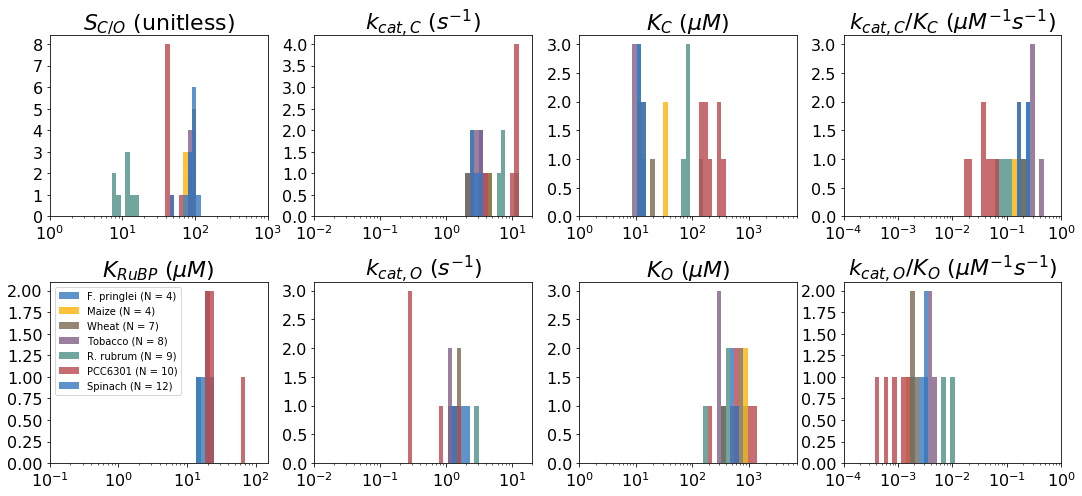

In [6]:
# Description of the data set
figure = plt.figure(figsize=(15,7))

cols = ['S', 'vC', 'KC', 'kon_C', 'KRuBP', 'vO', 'KO', 'kon_O']
titles = {'S': '$S_{C/O}$',
          'vC': '$k_{cat,C}$',
          'KC': '$K_C$',
          'vO': '$k_{cat,O}$',
          'KO': '$K_O$',
          'kon_C': '$k_{cat,C}/K_C$',
          'kon_O': '$k_{cat,O}/K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless',
         'vC': '$s^{-1}$',
         'KC': '$\mu M$',
         'vO': '$s^{-1}$',
         'KO': '$\mu M$',
         'kon_C': '$\mu M^{-1} s^{-1}$',
         'kon_O': '$\mu M^{-1} s^{-1}$',
         'KRuBP': '$\mu M$'}
xlim = {'S': (1, 1e3),
        'vC': (1e-2, 20),
        'vO':(1e-2, 20),
        'KC': (1, 7e3),
        'KO': (1, 7e3),
        'kon_C': (1e-4, 1e0),
        'kon_O': (1e-4, 1e0),
        'KRuBP': (0.1, 1.5e2)}
names = {'Flaveria pringlei': 'F. pringlei',
         'Zea mays': 'Maize',
         'Triticum aestivum': 'Wheat',
         'Nicotiana tabacum': 'Tobacco',
         'Rhodospirillum rubrum': 'R. rubrum',
         'Synechococcus 6301': 'PCC6301',
         'Spinacia oleracea': 'Spinach'}

nsub = len(cols)
pal = sns.color_palette('muted')

for i, c in enumerate(cols):
    ax = plt.subplot(2, nsub/2.0, i+1)
    plt.xscale('log')

    for j, (idx, gdf) in enumerate(sorted_groups):        
        color = named_colors[j % len(named_colors)] 
        short_name = names[idx[0]]
        label = '%s (N = %d)' % (short_name, gdf.shape[0])
        
        mask = gdf[c].notnull()
        bottom, top = xlim[c]
        bins = np.logspace(np.log10(bottom), np.log10(top), 50)
        plt.hist(gdf[mask][c], bins=bins, label=label, color=color, alpha=0.8)
        
        if c == 'KRuBP':
            plt.legend(loc=2, frameon=True, fontsize=10)
    
    plt.xlim(*xlim[c])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('')

    title = '%s (%s)' % (titles[c], units[c])
    plt.title(title, fontsize=22, ha='center')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.savefig('figS3/figS3_histograms_multiple_measurements.svg')
plt.savefig('figS3/figS3_histograms_multiple_measurements.png', dpi=400)

plt.show()